In [4]:
import h5py
import numpy as np
import pandas as pd
import anndata
import scipy.sparse as sp
import scanpy as sc
import random
import scipy.sparse
from scipy.stats import ks_2samp
from collections import defaultdict
from matplotlib.patches import Wedge
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

In [26]:
print('select sick dengue kids')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519.h5ad'
adata_D = anndata.read_h5ad(fn_h5ad)
adata_D = (adata_D[adata_D.obs['dataset'] == 'child'])[(adata_D[adata_D.obs['dataset'] == 'child']).obs['sick'] =='sick']

# delete information
#[['Healthy', 'cDCs', '3_074_01'],
# ['DWS', 'cDCs', '5_089_01'],
# ['S_dengue', 'cDCs', '1_140_01'],
# ['S_dengue', 'cDCs', '5_193_01']]

select sick dengue kids


In [35]:
print('select sick COVID patients')
adata_C = sc.read_h5ad('/home/yike/phd/dengue/data/dataset_from_google/COVID PBMC Italy/50__subtype__ID/adata_filter.h5ad')
adata_C = adata_C[adata_C.obs['sick'] == 'sick']
print("select 'timepoint' == 'T0'")
adata_C = adata_C[adata_C.obs['timepoint'] == 'T0']
print("select 'days_since_hospitalized' <= 10")
adata_C = adata_C[adata_C.obs['days_since_hospitalized'].isin(['1.0', '3.0', '0.0', '6.0', '9.0', '2.0', '7.0'])]

select sick COVID patients
select 'timepoint' == 'T0'
select 'days_since_hospitalized' <= 10


In [4]:
sc.pp.normalize_total(adata_D, target_sum=1e6) #normalize data to CPM (counts per million)
sc.pp.normalize_total(adata_C, target_sum=1e6) 

/home/yike/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
genes_D = adata_D.var_names
genes_C = adata_C.var_names
genes = [gene for gene in genes_D if gene in genes_C] 

In [201]:
adatag_D = adata_D[:, genes]
adatag_C = adata_C[:, genes]

In [ ]:
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

m = len(genes)
ress = pd.DataFrame([])
log2FC = pd.DataFrame([])

for cell_type in cell_types:
    adatag_D_ct = adatag_D[adatag_D.obs['cell_type'] == cell_type]
    adatag_C_ct = adatag_C[adatag_C.obs['cell_type'] == cell_type]
    IDs_D = list(adatag_D_ct.obs['ID'].astype('category').cat.categories)
    IDs_C = list(adatag_C_ct.obs['donor'].astype('category').cat.categories)
    
    log2_fc = []
    for ID_D in IDs_D:
        adatag_D_ID = adatag_D_ct[adatag_D_ct.obs['ID'] == ID_D]
        if len(adatag_D_ID.obs_names) < 5:
            continue
        for ID_C in IDs_C:
            adatag_C_ID = adatag_C_ct[adatag_C_ct.obs['donor'] == ID_C]
            if len(adatag_C_ID.obs_names) < 5:
                continue
                
            X_D = adatag_D_ID.X
            X_C = adatag_C_ID.X
            avg_D = np.asarray(X_D.mean(axis=0))[0]
            avg_C = np.asarray(X_C.mean(axis=0))[0]
            log2_fc.append(np.log2(avg_C + 0.1) - np.log2(avg_D + 0.1))
    
    log2_fc = np.asarray(log2_fc)
    med_pair = np.median(log2_fc, axis=0)
    fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

    res = pd.DataFrame([], index=adatag_D.var_names)
    res['med_pair'] = med_pair
    res['fra_pair'] = fra_pair
    res['cell_type'] = cell_type
    ress = pd.concat([ress, res])
        
    FCs = pd.DataFrame(log2_fc, columns = adatag_D.var_names, index=[cell_type] * log2_fc.shape[0])
    log2FC = pd.concat([log2FC, FCs])
    
ress.to_csv('/home/yike/phd/dengue/data/tables/pairs_vs_COVID.tsv')
log2FC.to_csv('/home/yike/phd/dengue/data/tables/pair_log2FC_vs_COVID.tsv')

In [ ]:
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

ress = pd.read_csv('/home/yike/phd/dengue/data/tables/pairs_vs_COVID.tsv', index_col=['cell_type', 'gene'])
write = pd.ExcelWriter('/home/yike/phd/dengue/data/tables/pairs_COVID_vs_dengue_filtered.xls')
for cell_type in cell_types:
    res = ress.loc[cell_type].sort_values('med_pair', ascending=True)
    res = res.loc[res[:100].index.tolist() + res[-100:].index.tolist()]
    res.to_excel(write, sheet_name=cell_type)
write.save()

In [24]:
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

ress = pd.read_csv('/home/yike/phd/dengue/data/tables/pairs_vs_COVID.tsv', index_col=['cell_type', 'gene'])
res = pd.DataFrame([])
for cell_type in cell_types:
    re = ress.loc[cell_type].sort_values('med_pair', ascending=True)
    idx = pd.Index([(cell_type, gene) for gene in (re[:100].index.tolist() + re[-100:].index.tolist())])
    re = ress.loc[idx]
    res = pd.concat([res, re])
res.to_csv('/home/yike/phd/dengue/data/tables/pairs_COVID_vs_dengue_filtered.tsv')

In [539]:
# filter genes meeting these criteria:
# 'med_pair' >= 1 & 'fra_pair' >= 0.9
# 'med_pair' <= -1 & 'fra_pair' <= 0.1
res = ress[((ress['med_pair'] >= 1) & (ress['fra_pair'] >= 0.9))| ((ress['med_pair'] <= -1) & (ress['fra_pair'] <= 0.1))]
print('filter %s out of %s genes'%(res.shape[0], ress.shape[0]))
res.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered.tsv')

filter 7251 out of 143983 genes


In [542]:
gs = [idx[1] for idx in res.index]
gs = list(set(gs))

res = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered.tsv', index_col=['cell_type', 'gene'])
f_res = pd.DataFrame([], columns = ['med_pair', 'fra_pair', 'avg_D', 'avg_C', 'log2_fold_change', 'cell_type', 'gene'])
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

i = 0
for gene in gs:
    n = 0
    cts = []
    for cell_type in cell_types:
        if gene in res.loc[cell_type].index.tolist():
            n += 1
            cts.append(cell_type)
    if n < 3:
        for ct in cts:
            i += 1
            loc = res.loc[(ct, gene)].tolist()
            loc.append(ct)
            loc.append(gene)
            f_res.loc[i] = loc
f_res.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered_<3cts.tsv')

In [522]:
def randomization(genes):
    '''
    genes = {
    ct1: [],
    ct2: [],
    ct3: [],
    }
    '''
    log2fc = defaultdict(list)
    pvalue = {}
    
    for cell_type in genes.keys():
        adatag_D = adata_D[adata_D.obs['cell_type'] == cell_type]
        adatag_C = adata_C[adata_C.obs['cell_type'] == cell_type]

        IDs_D = list(adatag_D.obs['ID'].astype('category').cat.categories)
        IDs_C = list(adatag_C.obs['donor'].astype('category').cat.categories)

        for ID_D in IDs_D:
            adatag_D_ID = adatag_D[adatag_D.obs['ID'] == ID_D]
            if len(adatag_D_ID.obs_names) < 5:
                adatag_D = adatag_D[~(adatag_D.obs['ID'] == ID_D)]

        for ID_C in IDs_C:
            adatag_C_ID = adatag_C[adatag_C.obs['donor'] == ID_C]
            if len(adatag_C_ID.obs_names) < 5:
                adatag_C = adatag_C[~(adatag_C.obs['donor'] == ID_C)]

        for gene in genes[cell_type]:
            X_D = adatag_D[:, gene].X.toarray()[:, 0]
            X_C = adatag_C[:, gene].X.toarray()[:, 0]
            avg_D = X_D.mean()
            avg_C = X_C.mean()
            lfc0 = np.log2(avg_D + 0.1) - np.log2(avg_C + 0.1)
            log2fc[(cell_type, gene)].append(lfc0)

            p = 0
            X = X_D.tolist() + X_C.tolist()
            for i in range(1000):
                idx_Di = random.sample(range(len(X)), len(X_D))
                X_Di = [X[i] for i in idx_Di]
                remain_idx = tuple(set(range(len(X))) - set(idx_Di))
                X_Ci = [X[i] for i in remain_idx]
                lfci = np.log2(np.mean(X_Di) + 0.1) - np.log2(np.mean(X_Ci) + 0.1)
                log2fc[(cell_type, gene)].append(lfci)
                if abs(lfci) >= abs(lfc0):
                    p += 1
            pvalue[(cell_type, gene)] = p * 0.001

    res = pd.DataFrame([])
    for key in log2fc.keys():
        log2fc[key] = pd.DataFrame(log2fc[key], columns = ['log2fc'])
        log2fc[key]['pvalue'] = pvalue[key]
        for i, s in enumerate(['cell_type', 'gene']):
            log2fc[key][s] = key[i]
        res = pd.concat([res, log2fc[key]])
    res = res.set_index(['cell_type', 'gene'])
        
    return res

In [634]:
f_res = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered_<3cts.tsv', index_col=['cell_type', 'gene'])
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']
genes_all = {ct: f_res.loc[ct].index.tolist() for ct in cell_types}

In [610]:
ran_res = randomization(genes_all)
ran_res.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/randomization_COVID_test_all.tsv')
ran_res.drop('Unnamed: 0', axis=1, inplace=True)
ran_res.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/randomization_COVID_test_all.tsv')

In [635]:
ran_res = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/randomization_COVID_test_all.tsv', index_col=['cell_type', 'gene'])

sig_res = pd.DataFrame([], columns = ['log2fc', 'pvalue', 'cell_type', 'gene'])
i = 0
for cell_type in genes_all.keys():
    for gene in genes_all[cell_type]:
        if ran_res.loc[cell_type, gene][:1]['pvalue'][0] == 0:
            i += 1
            loc = ran_res.loc[cell_type, gene][:1].loc[cell_type, gene].tolist()
            loc.append(cell_type)
            loc.append(gene)
            sig_res.loc[i] = loc
sig_res = sig_res.set_index(['cell_type', 'gene'])
sig_res.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/randomization_COVID_sig.tsv')

<ipython-input-635-5ae523271d99>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  if ran_res.loc[cell_type, gene][:1]['pvalue'][0] == 0:
<ipython-input-635-5ae523271d99>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  loc = ran_res.loc[cell_type, gene][:1].loc[cell_type, gene].tolist()


In [636]:
sig_pair = f_res.loc[sig_res.index]
sig_pair.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered_<3cts_sig.tsv')
fra_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv', index_col=['cell_type', 'gene'])
fra_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv', index_col=['cell_type', 'gene'])
sig_pair['fra_D'] = fra_D.loc[sig_pair.index]['fra_D']
sig_pair['fra_C'] = fra_C.loc[sig_pair.index]['fra_C']
sig_pair.drop('Unnamed: 0', axis=1, inplace=True)
sig_pair.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered_<3cts_sig.tsv')

In [645]:
sig_pair = sig_pair[((sig_pair['med_pair'] < 0) & (sig_pair['fra_D'] >= 0.05)) | ((sig_pair['med_pair'] > 0) & (sig_pair['fra_C'] >= 0.05))]
sig_pair.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/pairs_COVID_vs_dengue_filtered_<3cts_sig_fra.tsv')

In [533]:
D_genes = sig_pair[sig_pair['log2_fold_change'] < 0]
#D_genes = list(set([idx[1] for idx in D_genes.index]))
#len(D_genes)

In [534]:
D_genes

,,med_pair,fra_pair,avg_D,avg_C,log2_fold_change
cell_type,gene,,,,,


In [535]:
C_genes = sig_pair[sig_pair['log2_fold_change'] > 0]
C_genes = list(set([idx[1] for idx in C_genes.index]))
C_genes

['MYO1F',
 'PTS',
 'CREB3L2',
 'GS1-124K5.4',
 'MTR',
 'BNIP3L',
 'ZNF451',
 'METTL16',
 'ADCY3',
 'ING3',
 'OGT',
 'PAIP2',
 'RNF145',
 'TNFSF8',
 'ZBTB10',
 'ACADVL',
 'KDM4C',
 'TGFBR3',
 'C15orf39',
 'EEF2',
 'ACAP1',
 'SIAH2',
 'IRF2BPL',
 'SIDT2',
 'RNF10',
 'ABHD14B',
 'UBR5',
 'NR4A1',
 'AUP1',
 'NIPBL',
 'TOM1',
 'SLA2',
 'SEC24D',
 'RASSF1',
 'RAF1',
 'ZNF668',
 'RPRD1B',
 'KMT2C',
 'VPS13B',
 'HLA-B',
 'AKAP8L',
 'DNAJC10',
 'BRD1',
 'CTDSPL2',
 'IRF8',
 'TMF1',
 'VASH2',
 'AC017002.2',
 'SEMA6B',
 'IL1R2',
 'COL6A2',
 'AL807752.1',
 'RAB11FIP1',
 'GORASP2',
 'REPS1',
 'H1FX',
 'TWISTNB',
 'PTPN7',
 'SCAF8',
 'GOT1',
 'JUND',
 'NSUN3',
 'GNAO1',
 'TRMT6',
 'AOAH',
 'STX12',
 'CD79B',
 'IMPDH1',
 'SPATS2',
 'KBTBD2',
 'SERINC1',
 'USP4',
 'NGDN',
 'GPN2',
 'ATF7IP2',
 'RPSAP58',
 'PRR7',
 'GRB2',
 'HIVEP1',
 'EML4',
 'TRIM11',
 'DGKE',
 'USP42',
 'CD55',
 'STAT4',
 'DNAJB6',
 'CHD7',
 'ARHGAP24',
 'NAA15',
 'SNHG8',
 'NPC1',
 'EVA1C',
 'RABAC1',
 'TNFRSF12A',
 'ATP1A3',
 'ELM

In [649]:
Mo = sig_pair.loc['Monocytes'].sort_values('med_pair')

In [650]:
Mo[(Mo['fra_pair'] < 0.1)][:10].index

Index(['CXCL10', 'DEFB1', 'AIM2', 'NEXN', 'RSAD2', 'SERPING1', 'NHSL2',
       'DDX58', 'USP18', 'FBXO22'],
      dtype='object', name='gene')

In [651]:
 Mo[(Mo['fra_pair'] > 0.9)][-10:].index

Index(['P2RX1', 'THBD', 'TUBB6', 'CHKA', 'FCAR', 'EREG', 'ASPH', 'NAB2',
       'SEMA6B', 'TNFRSF12A'],
      dtype='object', name='gene')

In [652]:
B = sig_pair.loc['B_cells'].sort_values('med_pair')
#B

In [653]:
T = sig_pair.loc['T_cells'].sort_values('med_pair')
#T

In [654]:
NK = sig_pair.loc['NK_cells'].sort_values('med_pair')
#NK

In [655]:
Pla = sig_pair.loc['Plasmablasts'].sort_values('med_pair')
#Pla

In [656]:
cDC = sig_pair.loc['cDCs'].sort_values('med_pair')
#cDC

In [657]:
pDC = sig_pair.loc['pDCs'].sort_values('med_pair')
#pDC

In [242]:
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

avg_D = pd.DataFrame([])
avg_C = pd.DataFrame([])

for cell_type in cell_types:
    adatag_D_ct = adatag_D[adatag_D.obs['cell_type'] == cell_type]
    adatag_C_ct = adatag_C[adatag_C.obs['cell_type'] == cell_type]
    
    avg_D_ct = np.asarray(adatag_D_ct.X.mean(axis=0))[0]
    avg_D_ct = pd.DataFrame(avg_D_ct, index=adatag_D_ct.var_names)
    avg_D_ct['cell_type'] = cell_type
    avg_D = pd.concat([avg_D, avg_D_ct])

    avg_C_ct = np.asarray(adatag_C_ct.X.mean(axis=0))[0]
    avg_C_ct = pd.DataFrame(avg_C_ct, index=adatag_C_ct.var_names)
    avg_C_ct['cell_type'] = cell_type
    avg_C = pd.concat([avg_C, avg_C_ct])

avg_C.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_C.tsv')
avg_D.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_D.tsv')

avg_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_C.tsv')
avg_C = avg_C.rename(columns={'0': 'avg_C', 'Unnamed: 0': 'gene'})
avg_C.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_C.tsv')


avg_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_D.tsv')
avg_D = avg_D.rename(columns={'0': 'avg_D', 'Unnamed: 0': 'gene'})
avg_D.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_D.tsv')

In [384]:
cell_types = ['Monocytes', 'Plasmablasts', 'B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']

fra_D = pd.DataFrame([])
fra_C = pd.DataFrame([])

for cell_type in cell_types:
    adatag_D_ct = adatag_D[adatag_D.obs['cell_type'] == cell_type]
    adatag_C_ct = adatag_C[adatag_C.obs['cell_type'] == cell_type]
    
    fra_D_ct = np.asarray((adatag_D_ct.X > 0).mean(axis=0))[0]
    fra_D_ct = pd.DataFrame(fra_D_ct, index=adatag_D_ct.var_names)
    fra_D_ct['cell_type'] = cell_type
    fra_D = pd.concat([fra_D, fra_D_ct])

    fra_C_ct = np.asarray((adatag_C_ct.X > 0).mean(axis=0))[0]
    fra_C_ct = pd.DataFrame(fra_C_ct, index=adatag_C_ct.var_names)
    fra_C_ct['cell_type'] = cell_type
    fra_C = pd.concat([fra_C, fra_C_ct])

fra_C.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv')
fra_D.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv')

fra_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv')
fra_C = fra_C.rename(columns={'0': 'fra_C', 'Unnamed: 0': 'gene'})
fra_C.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv')

fra_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv')
fra_D = fra_D.rename(columns={'0': 'fra_D', 'Unnamed: 0': 'gene'})
fra_D.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv')

fra_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv', index_col=['cell_type', 'gene'])
fra_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv', index_col=['cell_type', 'gene'])

fra_C.drop('Unnamed: 0', axis=1, inplace=True)
fra_D.drop('Unnamed: 0', axis=1, inplace=True)
fra_C.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv')
fra_D.to_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv')

In [661]:
def mushrooms(genes):
    '''
    genes = {
    'CXCL10', 
    'DPP4',
    'ITGB2'
    }
    '''
    from matplotlib.patches import Wedge
    import matplotlib as mpl
    import math
    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3.5
    #threshold = 0.5
    avg_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_C.tsv', index_col=['cell_type', 'gene'], squeeze=True)
    avg_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/avg_D.tsv', index_col=['cell_type', 'gene'], squeeze=True)
    
    fra_C = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_C.tsv', index_col=['cell_type', 'gene'])
    fra_D = pd.read_csv('/home/yike/phd/dengue/data/tables/vs COVID/fra_D.tsv', index_col=['cell_type', 'gene'])
    
    conditions = [avg_C, avg_D]
    fracs = [fra_C, fra_D]

    yl = len(genes)
    fig = plt.figure(figsize=((1 + 0.8 * len(cell_types)) * 0.6, (1 + yl) * 0.6), dpi=300)          
    grid = plt.GridSpec(yl , len(cell_types) + 1, wspace=0.1, hspace=0.1)
    ax = plt.subplot(grid[0: yl, 0: len(cell_types)])                
    size_bar = plt.subplot(grid[1: 6, len(cell_types): len(cell_types) + 1])
                          
    datap = [] 
    for i, gene in enumerate(genes):
        for j, cst in enumerate(cell_types):
            avgs = []                
            for k, (cond, frac) in enumerate(zip(conditions, fracs)):
                av = np.log10(cond.loc[(cst, gene)] + 0.1)
                avgs.append(av)
                fr = frac.loc[(cst, gene)]
                r = 0.5 * fr ** 0.3            
                color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                datap.append({
                    'facecolor': color,
                    'r': r,
                    'center': (j, i),
                    'theta': (theta0, theta1),
                })
            #if avgs[0] - avgs[1] > threshold:
            #    datap[-2]['edgecolor'] = 'red'
            #    datap[-1]['edgecolor'] = 'none'
            #elif avgs[0] - avgs[1] < -threshold:
            #    datap[-1]['edgecolor'] = 'red'
            #    datap[-2]['edgecolor'] = 'none'
            #else:
            #    datap[-1]['edgecolor'] = 'none'
            #    datap[-2]['edgecolor'] = 'none' 

    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes)
    ax.set_ylim(-0.6, len(genes) - 0.4)        
    ax.set_xticks(np.arange(len(cell_types)))
    ax.set_xticklabels([x.replace('_', ' ') for x in cell_types], rotation=90)
    ax.set_xlim(-0.6, len(cell_types) - 0.4)
    
    for datum in datap:
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        #ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color,# edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)
    
    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)    
                          
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.83, 0.2, 0.05, 2/yl]) # [left, bottom, width, height]
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=ax, label='Gene exp (log10[cpm+0.1])')

    fig.tight_layout()

    return {'fig': fig, 'ax': ax}

In [461]:
#genes = ['CXCL10', 
#'ZBTB43', 'GPR183', 'DDIT4', 'ASPH', 'MT-ATP8', 'AREG', 'RGCC', 'SCO2',
#'S100A8', 'NFKBID', 'TNFAIP3', 'SNX9', 'GRASP',
#'TWF2', 'PRR13',
#'AREG', 'S100A8', 'GRASP', 'CXCR4',
#'PMAIP1', 'PELI1', 'FOS', 'KLF6', 'DDIT4', 'IGLL5', 'ZFP36', 'MT-ATP8', 'FOSB', 'TSC22D3', 'PTPRCAP', 'CD69', 'CXCR4', 'DUSP1',
#'STMN1', 
#'GRAMD1B', 'RASGEF1B', 'PFKFB3']

#mushrooms(genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

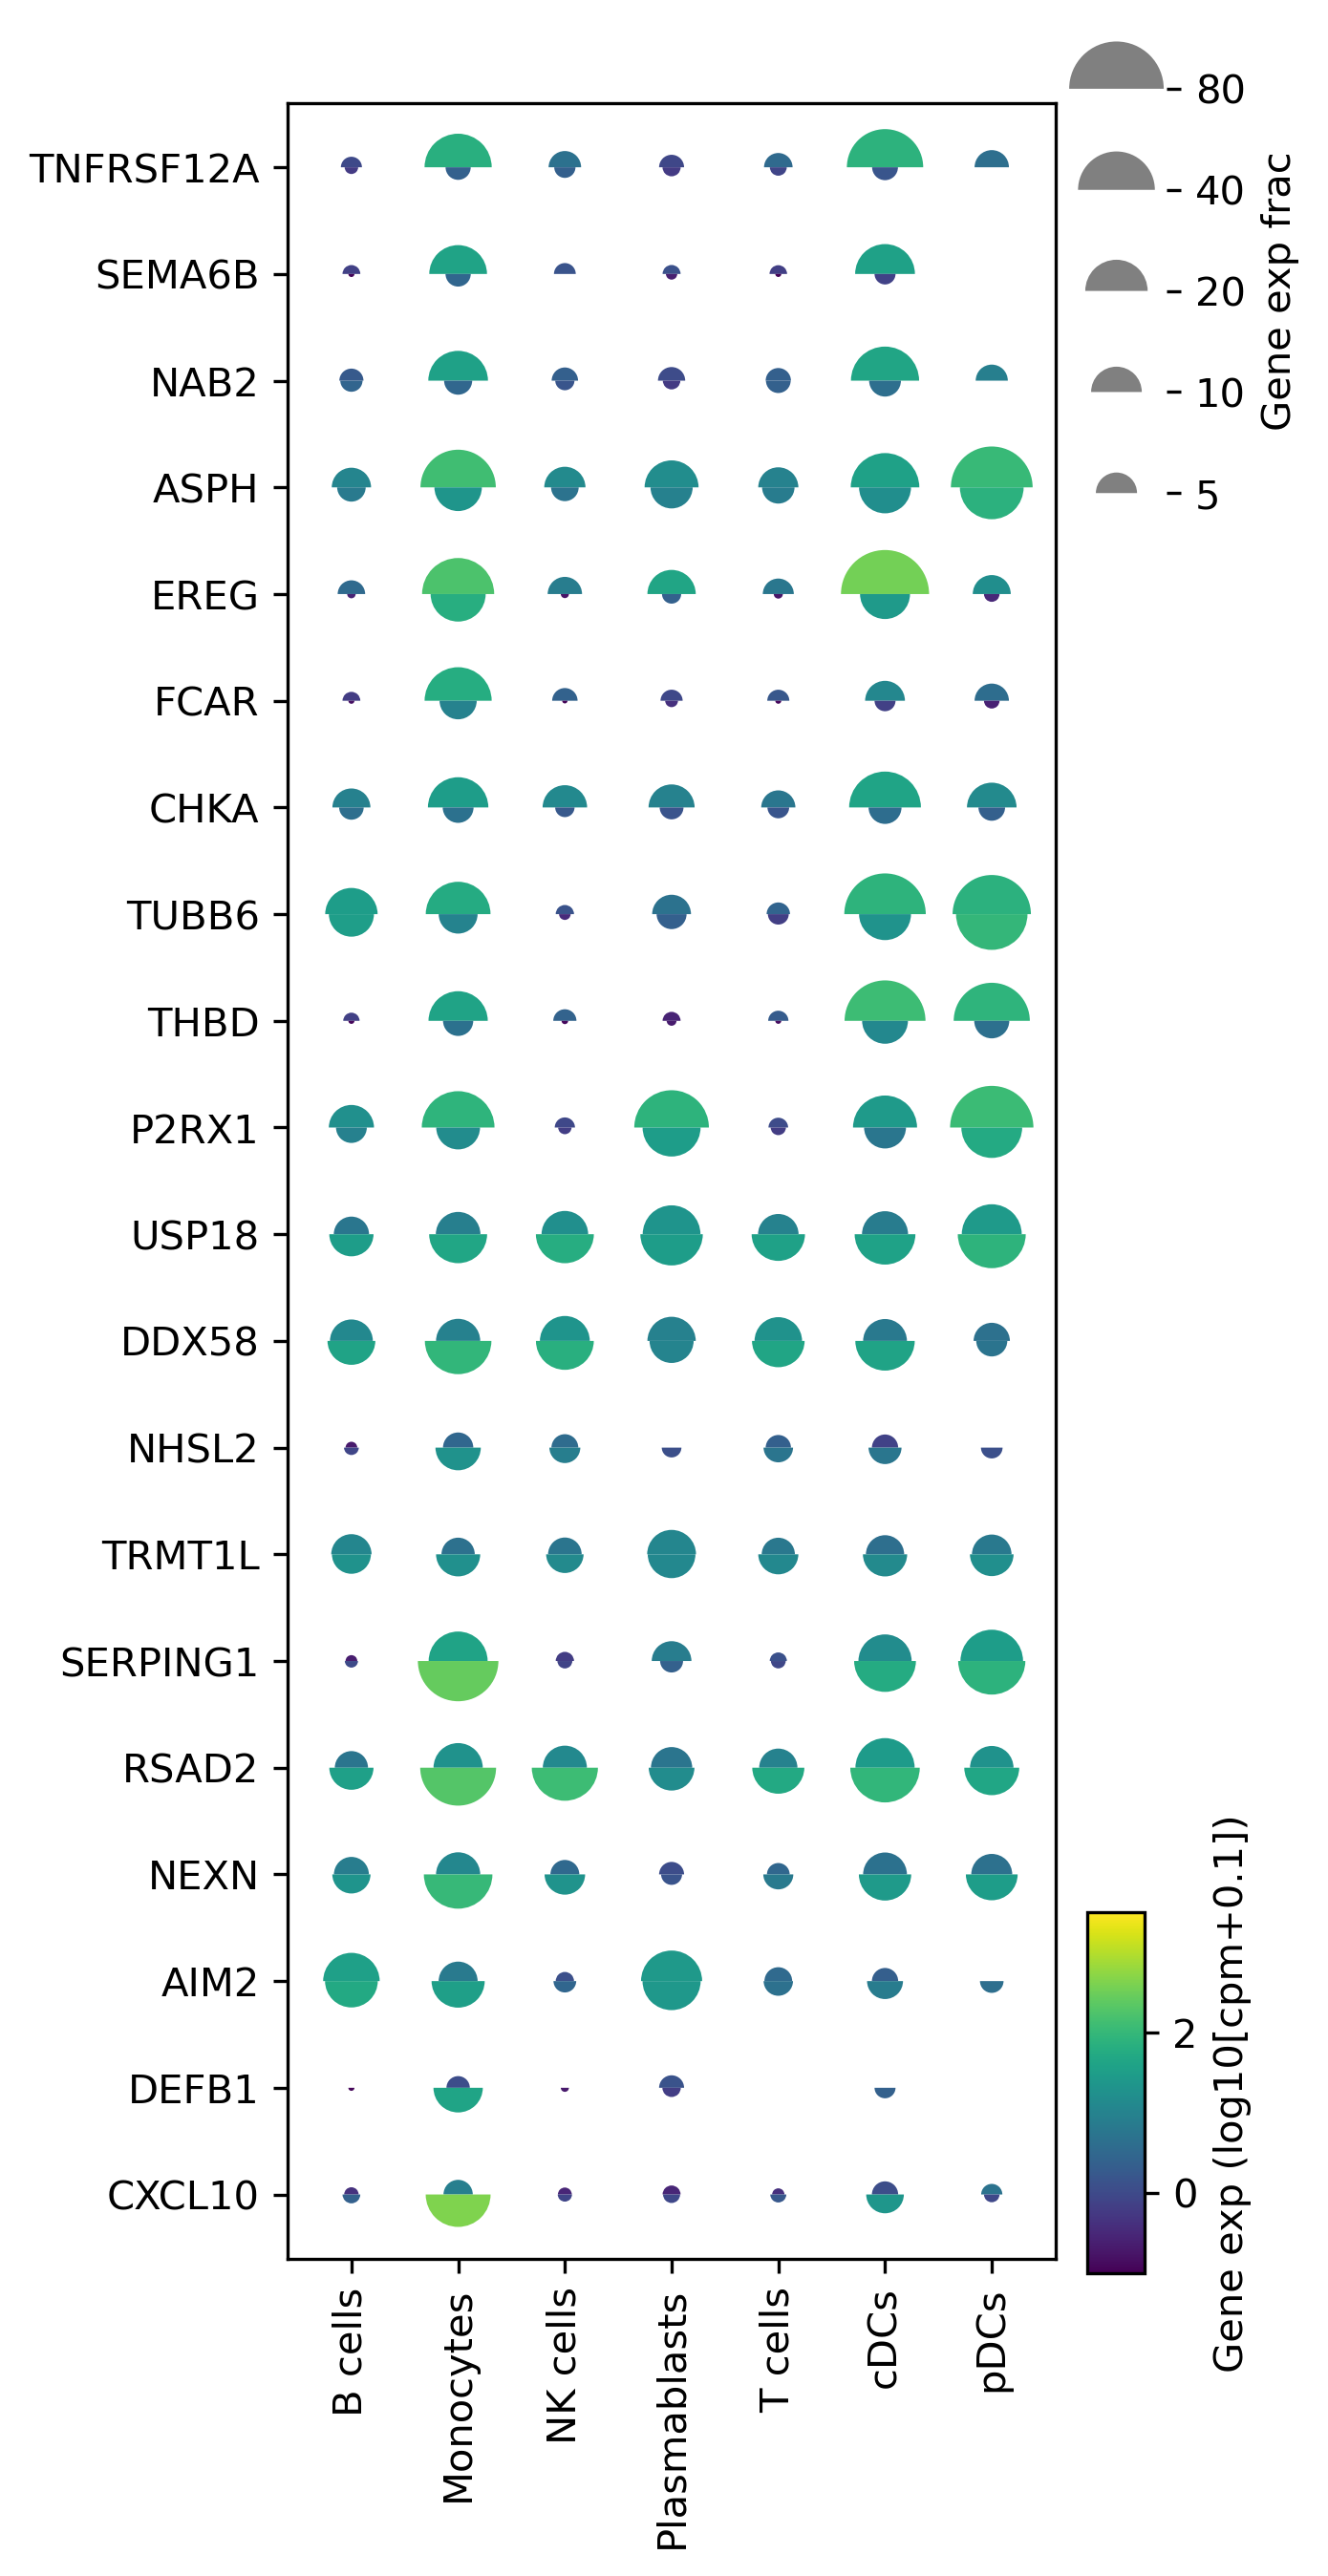

In [662]:
Mo_genes = Mo[:10].index.tolist() + Mo[-10:].index.tolist()
mushrooms(Mo_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

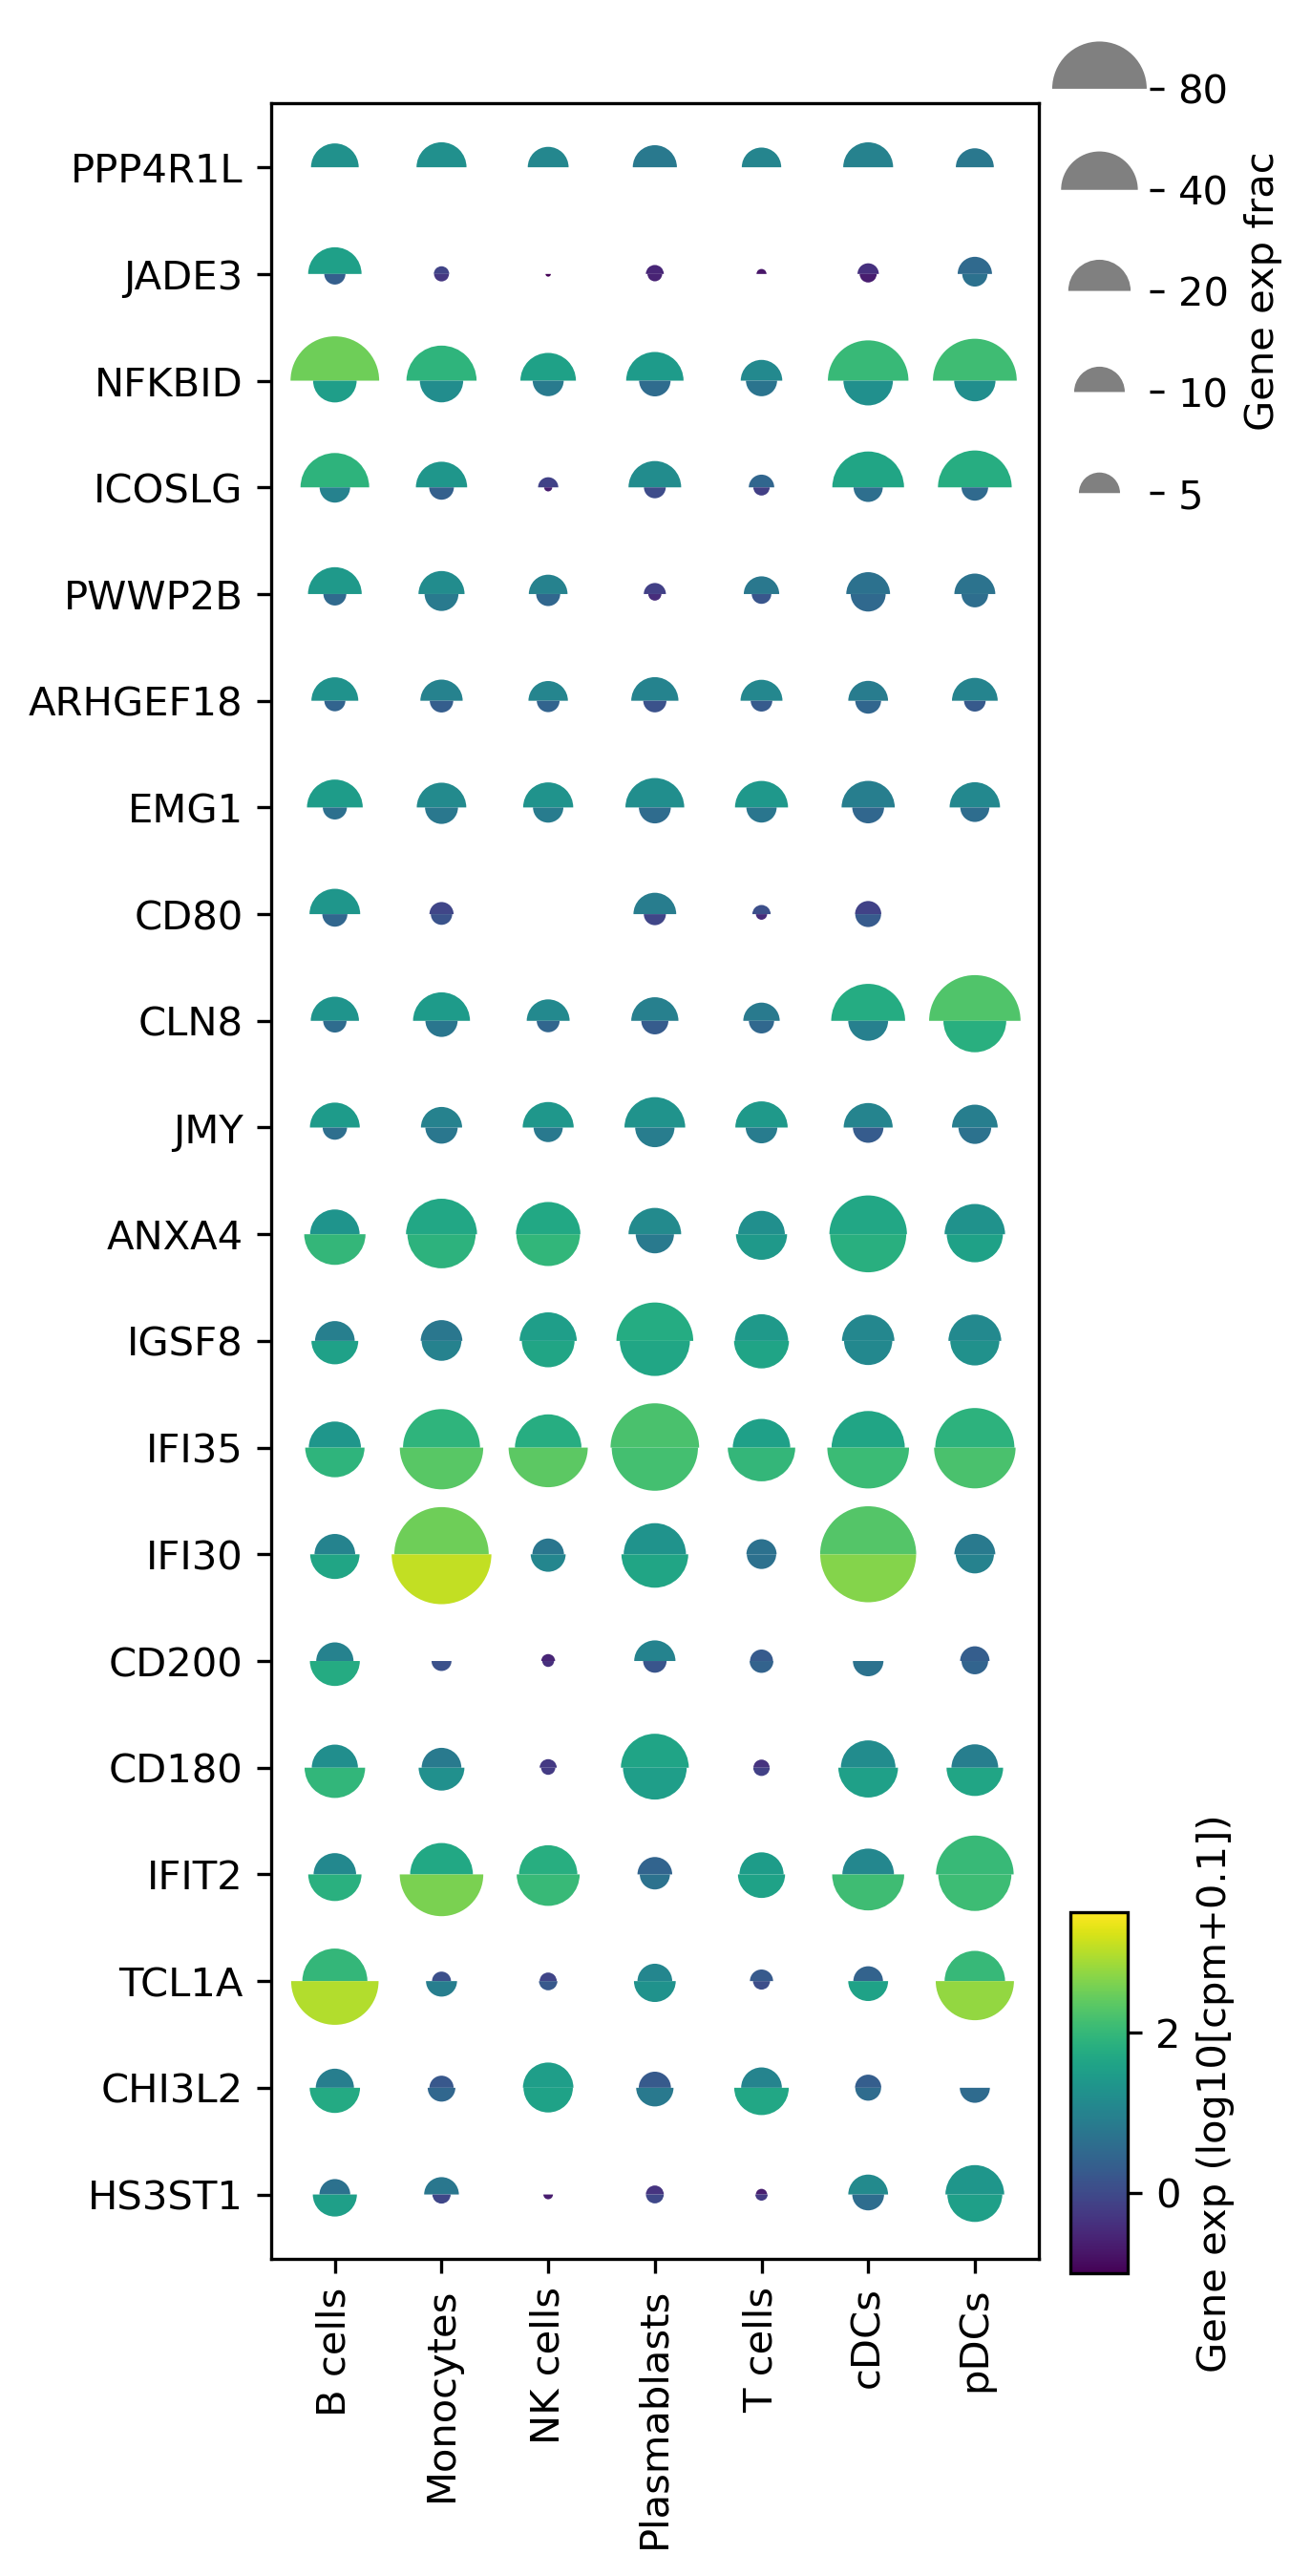

In [663]:
B_genes = B[:10].index.tolist() + B[-10:].index.tolist()
mushrooms(B_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

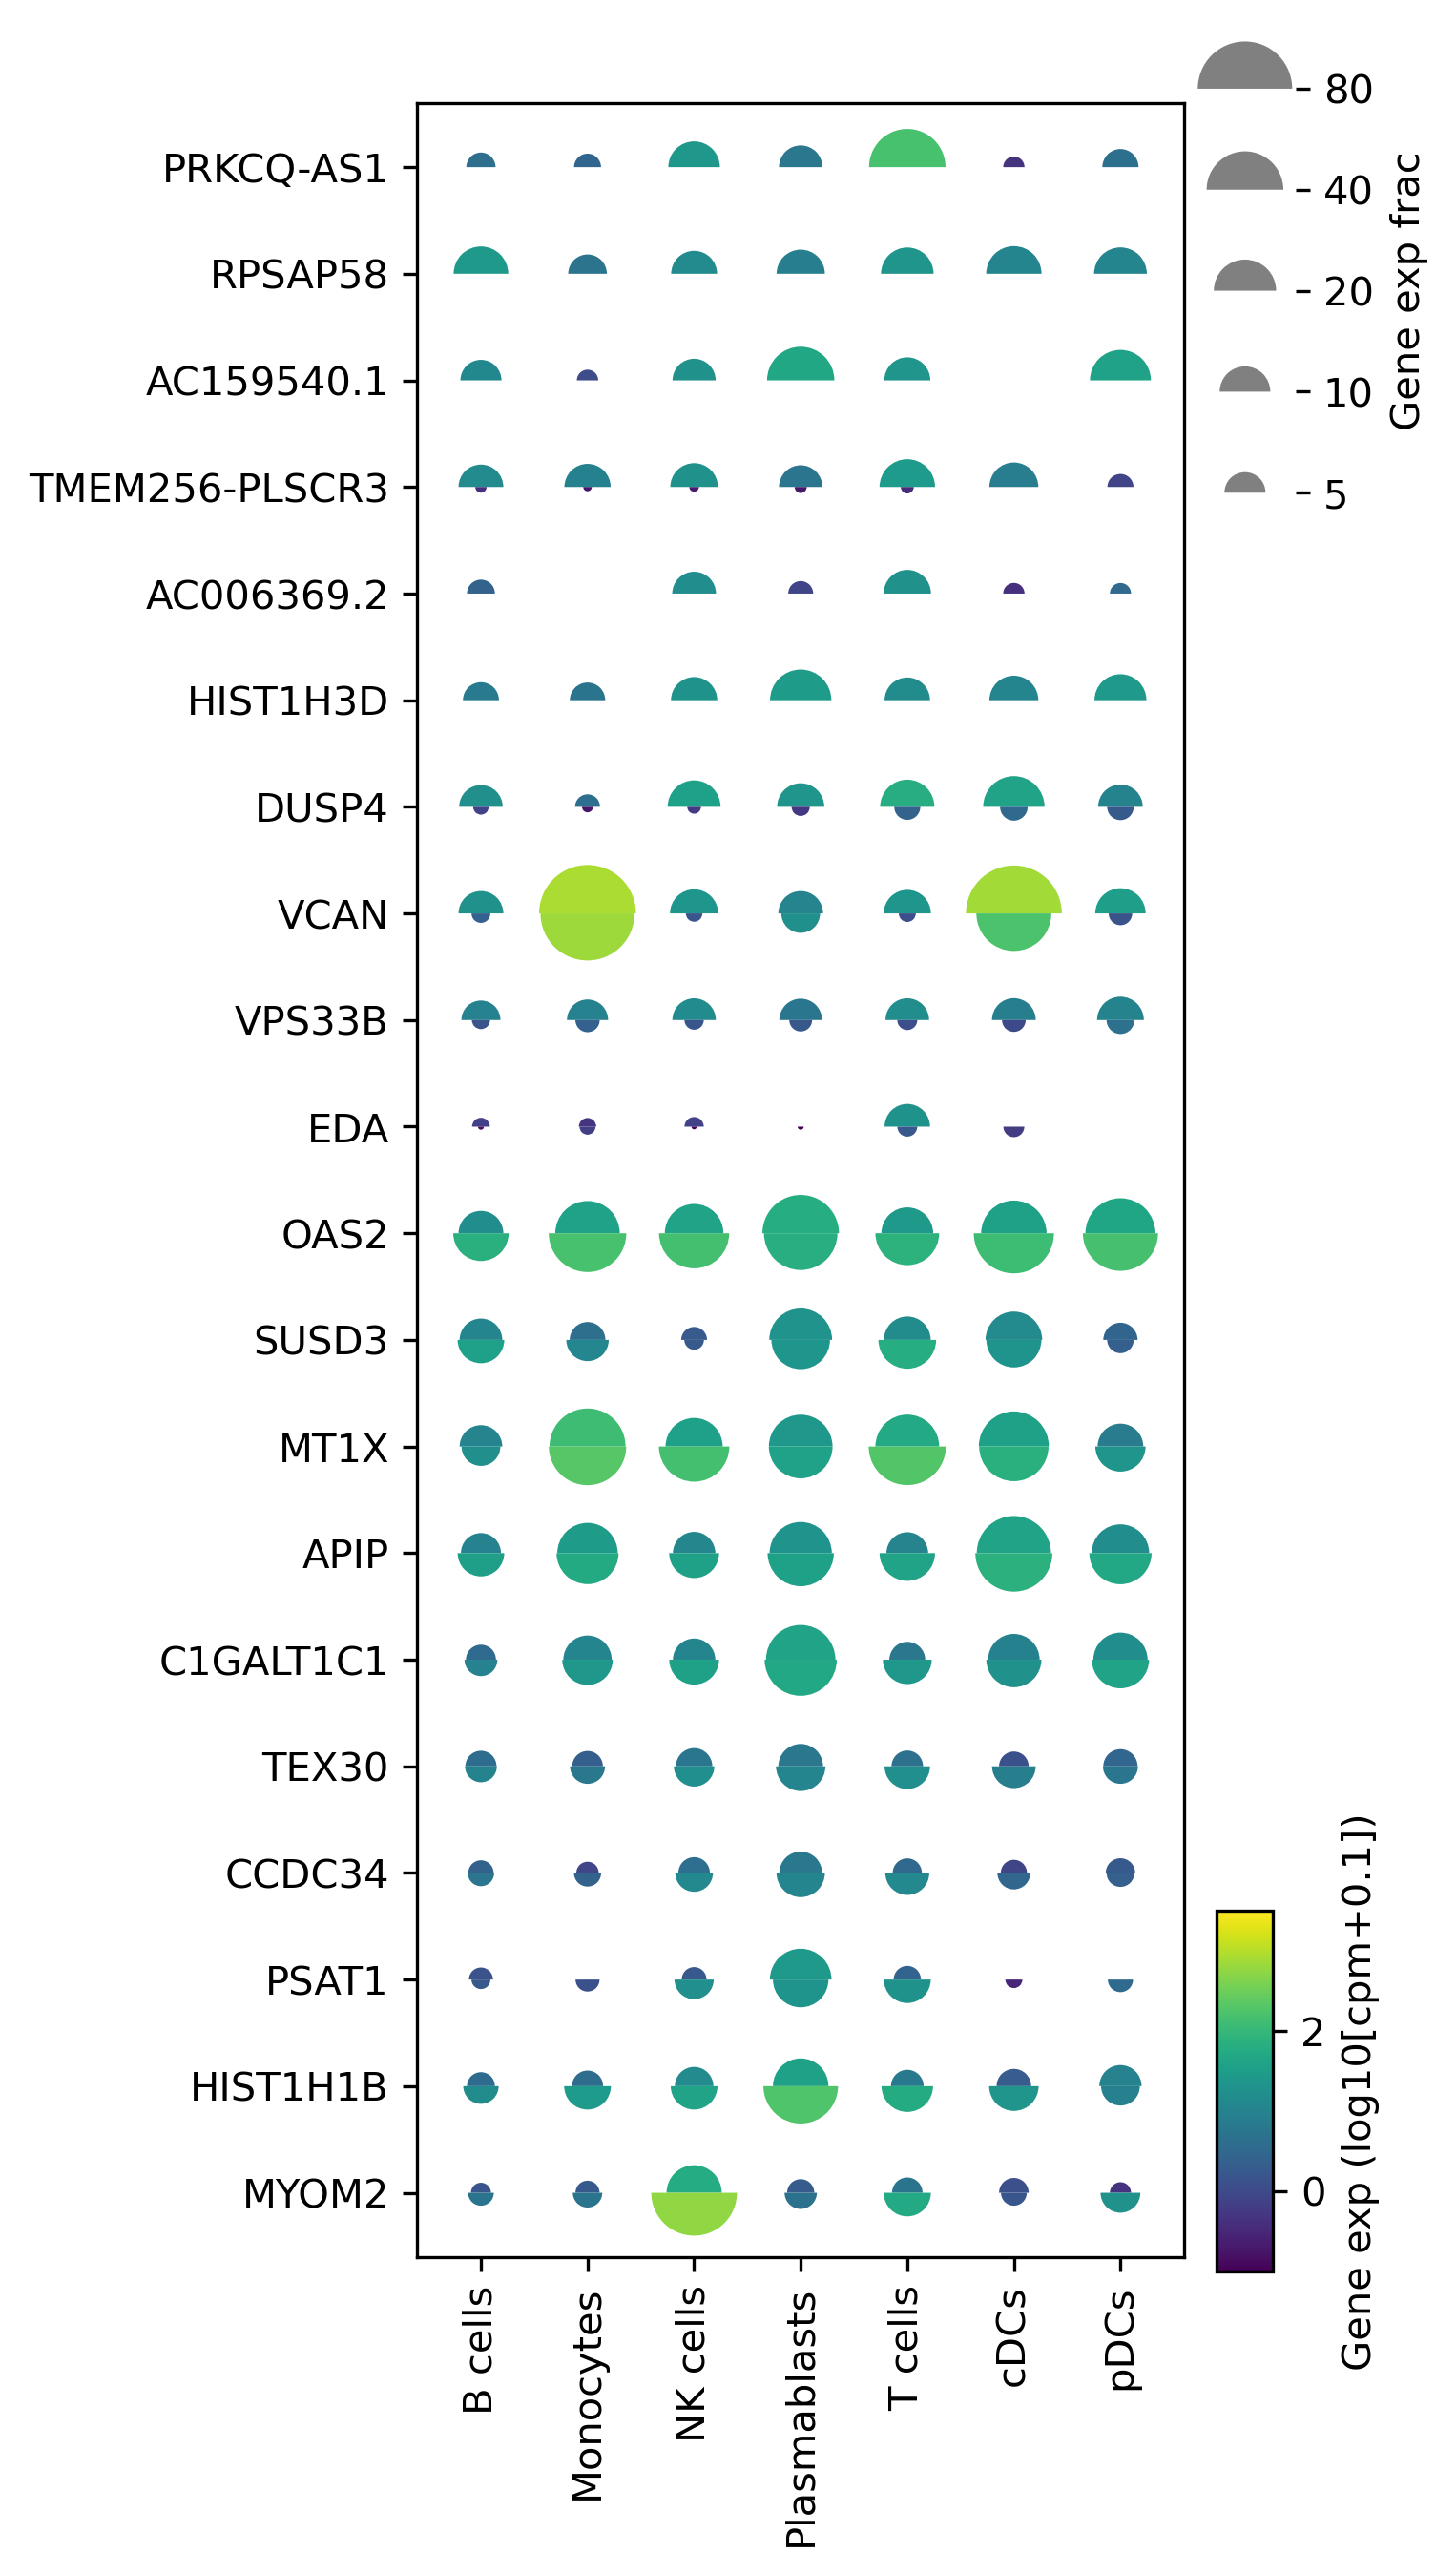

In [668]:
T_genes = T[:10].index.tolist() + T[-10:].index.tolist()
mushrooms(T_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

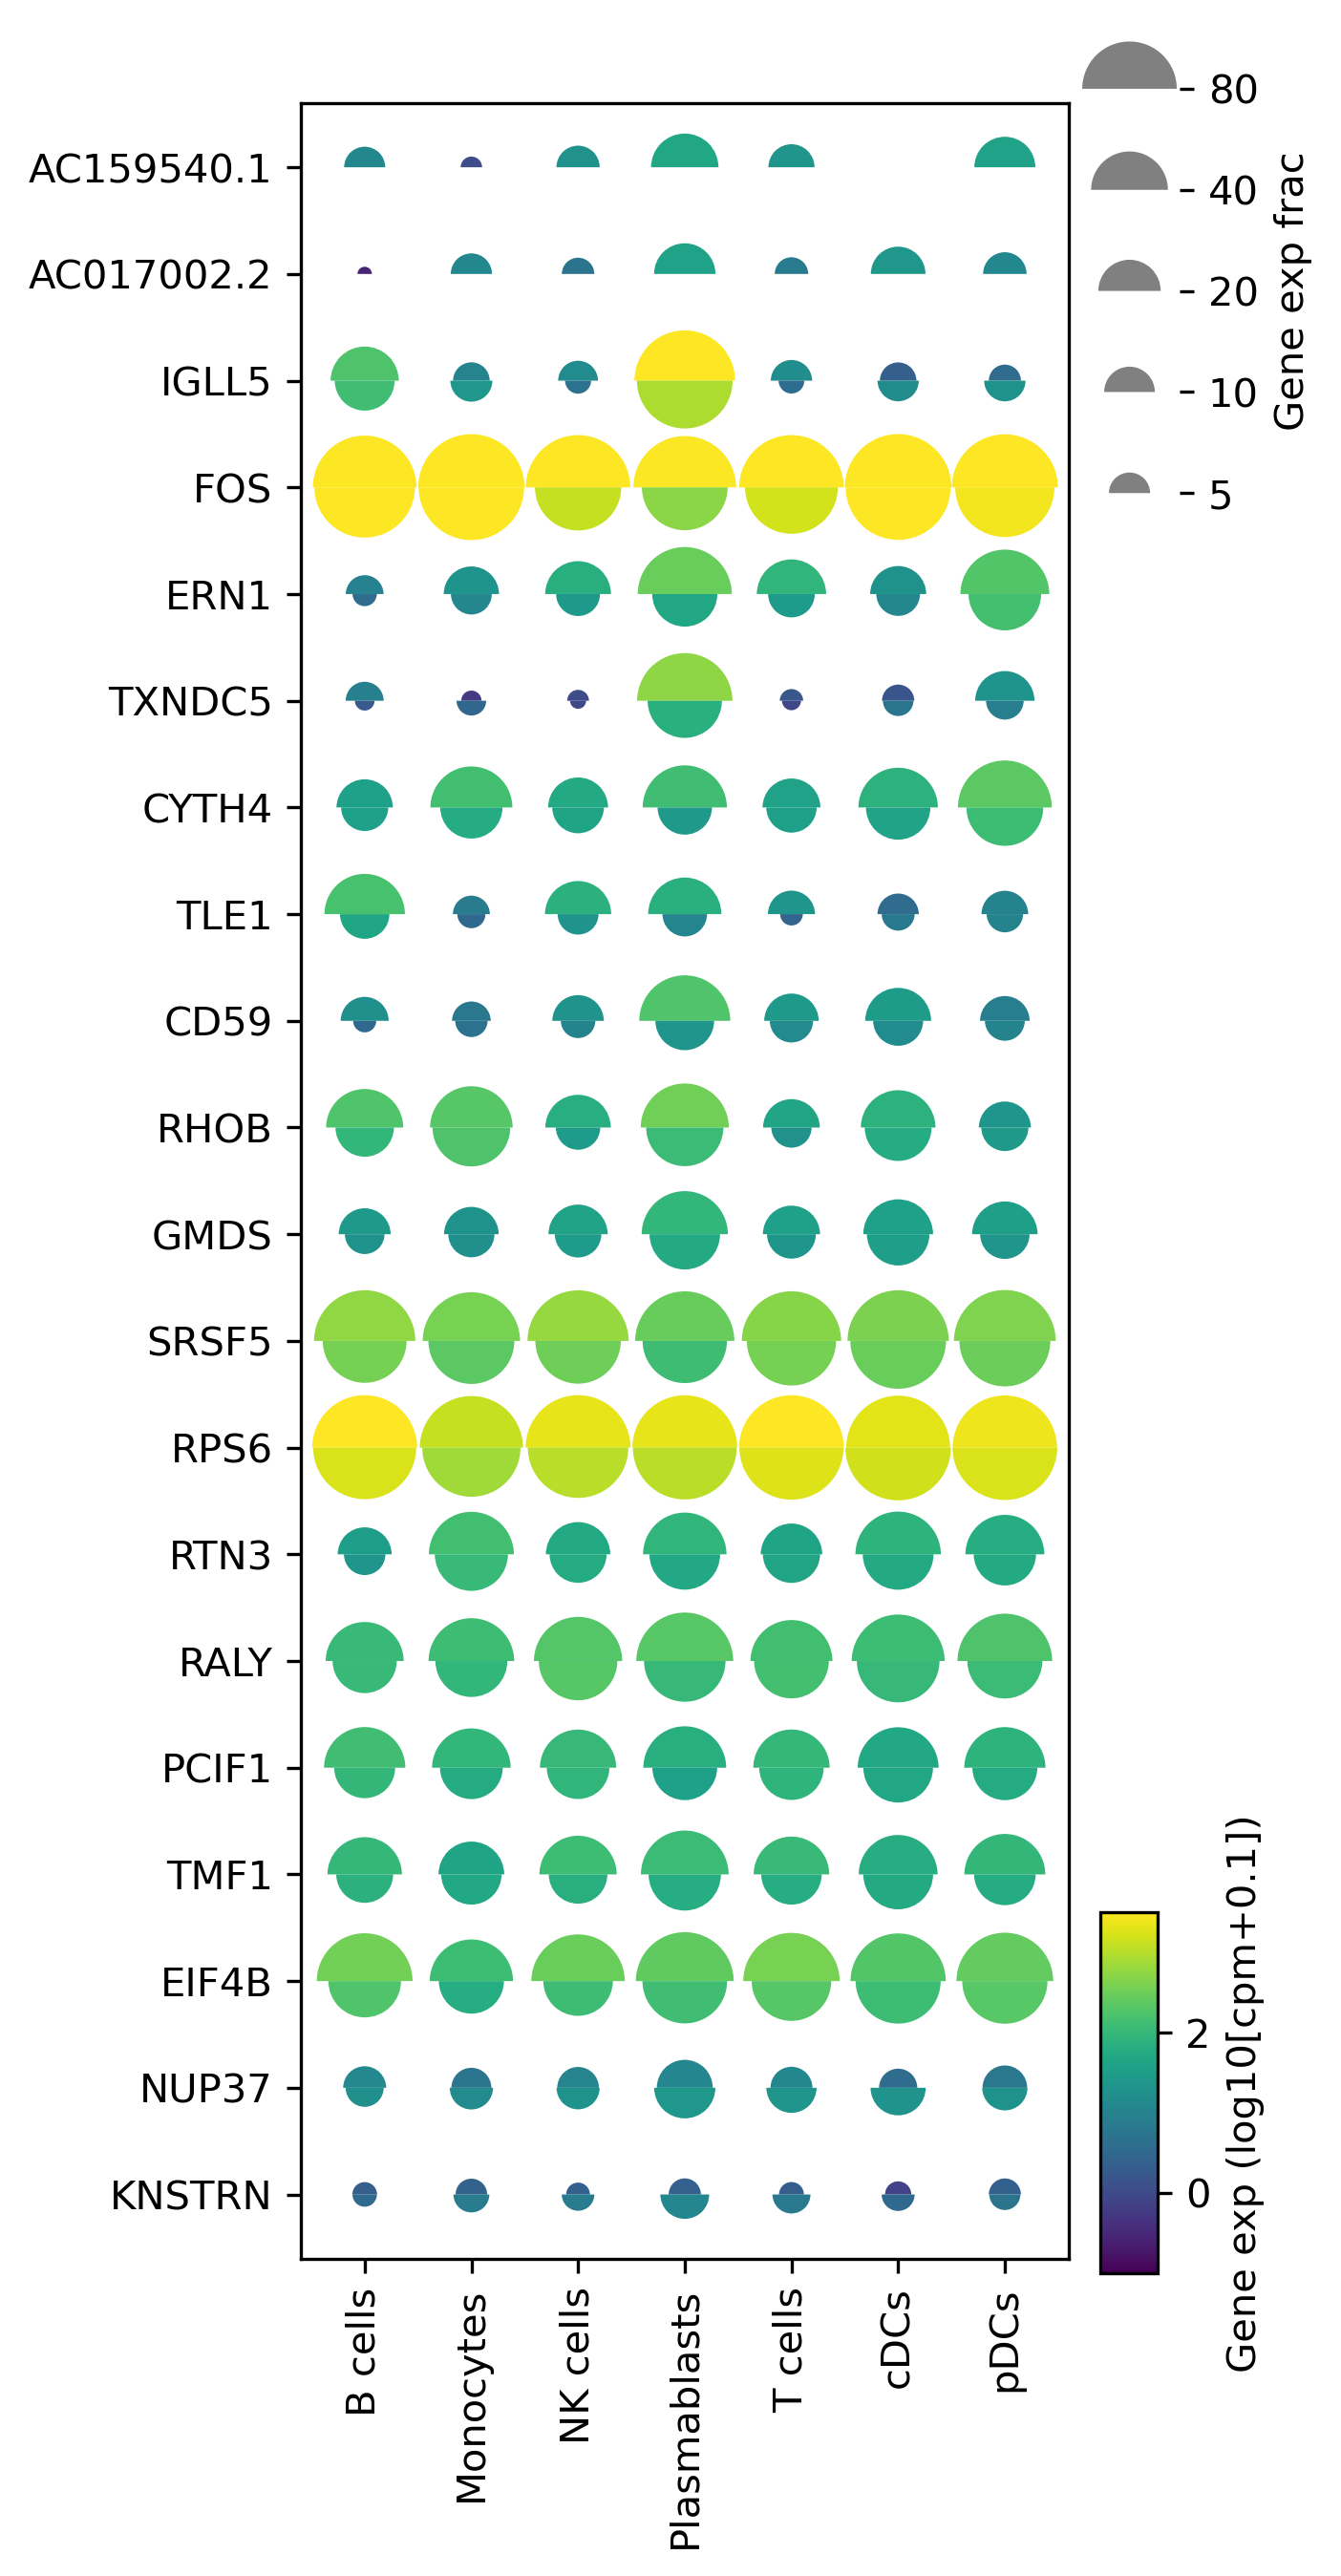

In [669]:
Pla_genes = Pla[:10].index.tolist() + Pla[-10:].index.tolist()
mushrooms(Pla_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

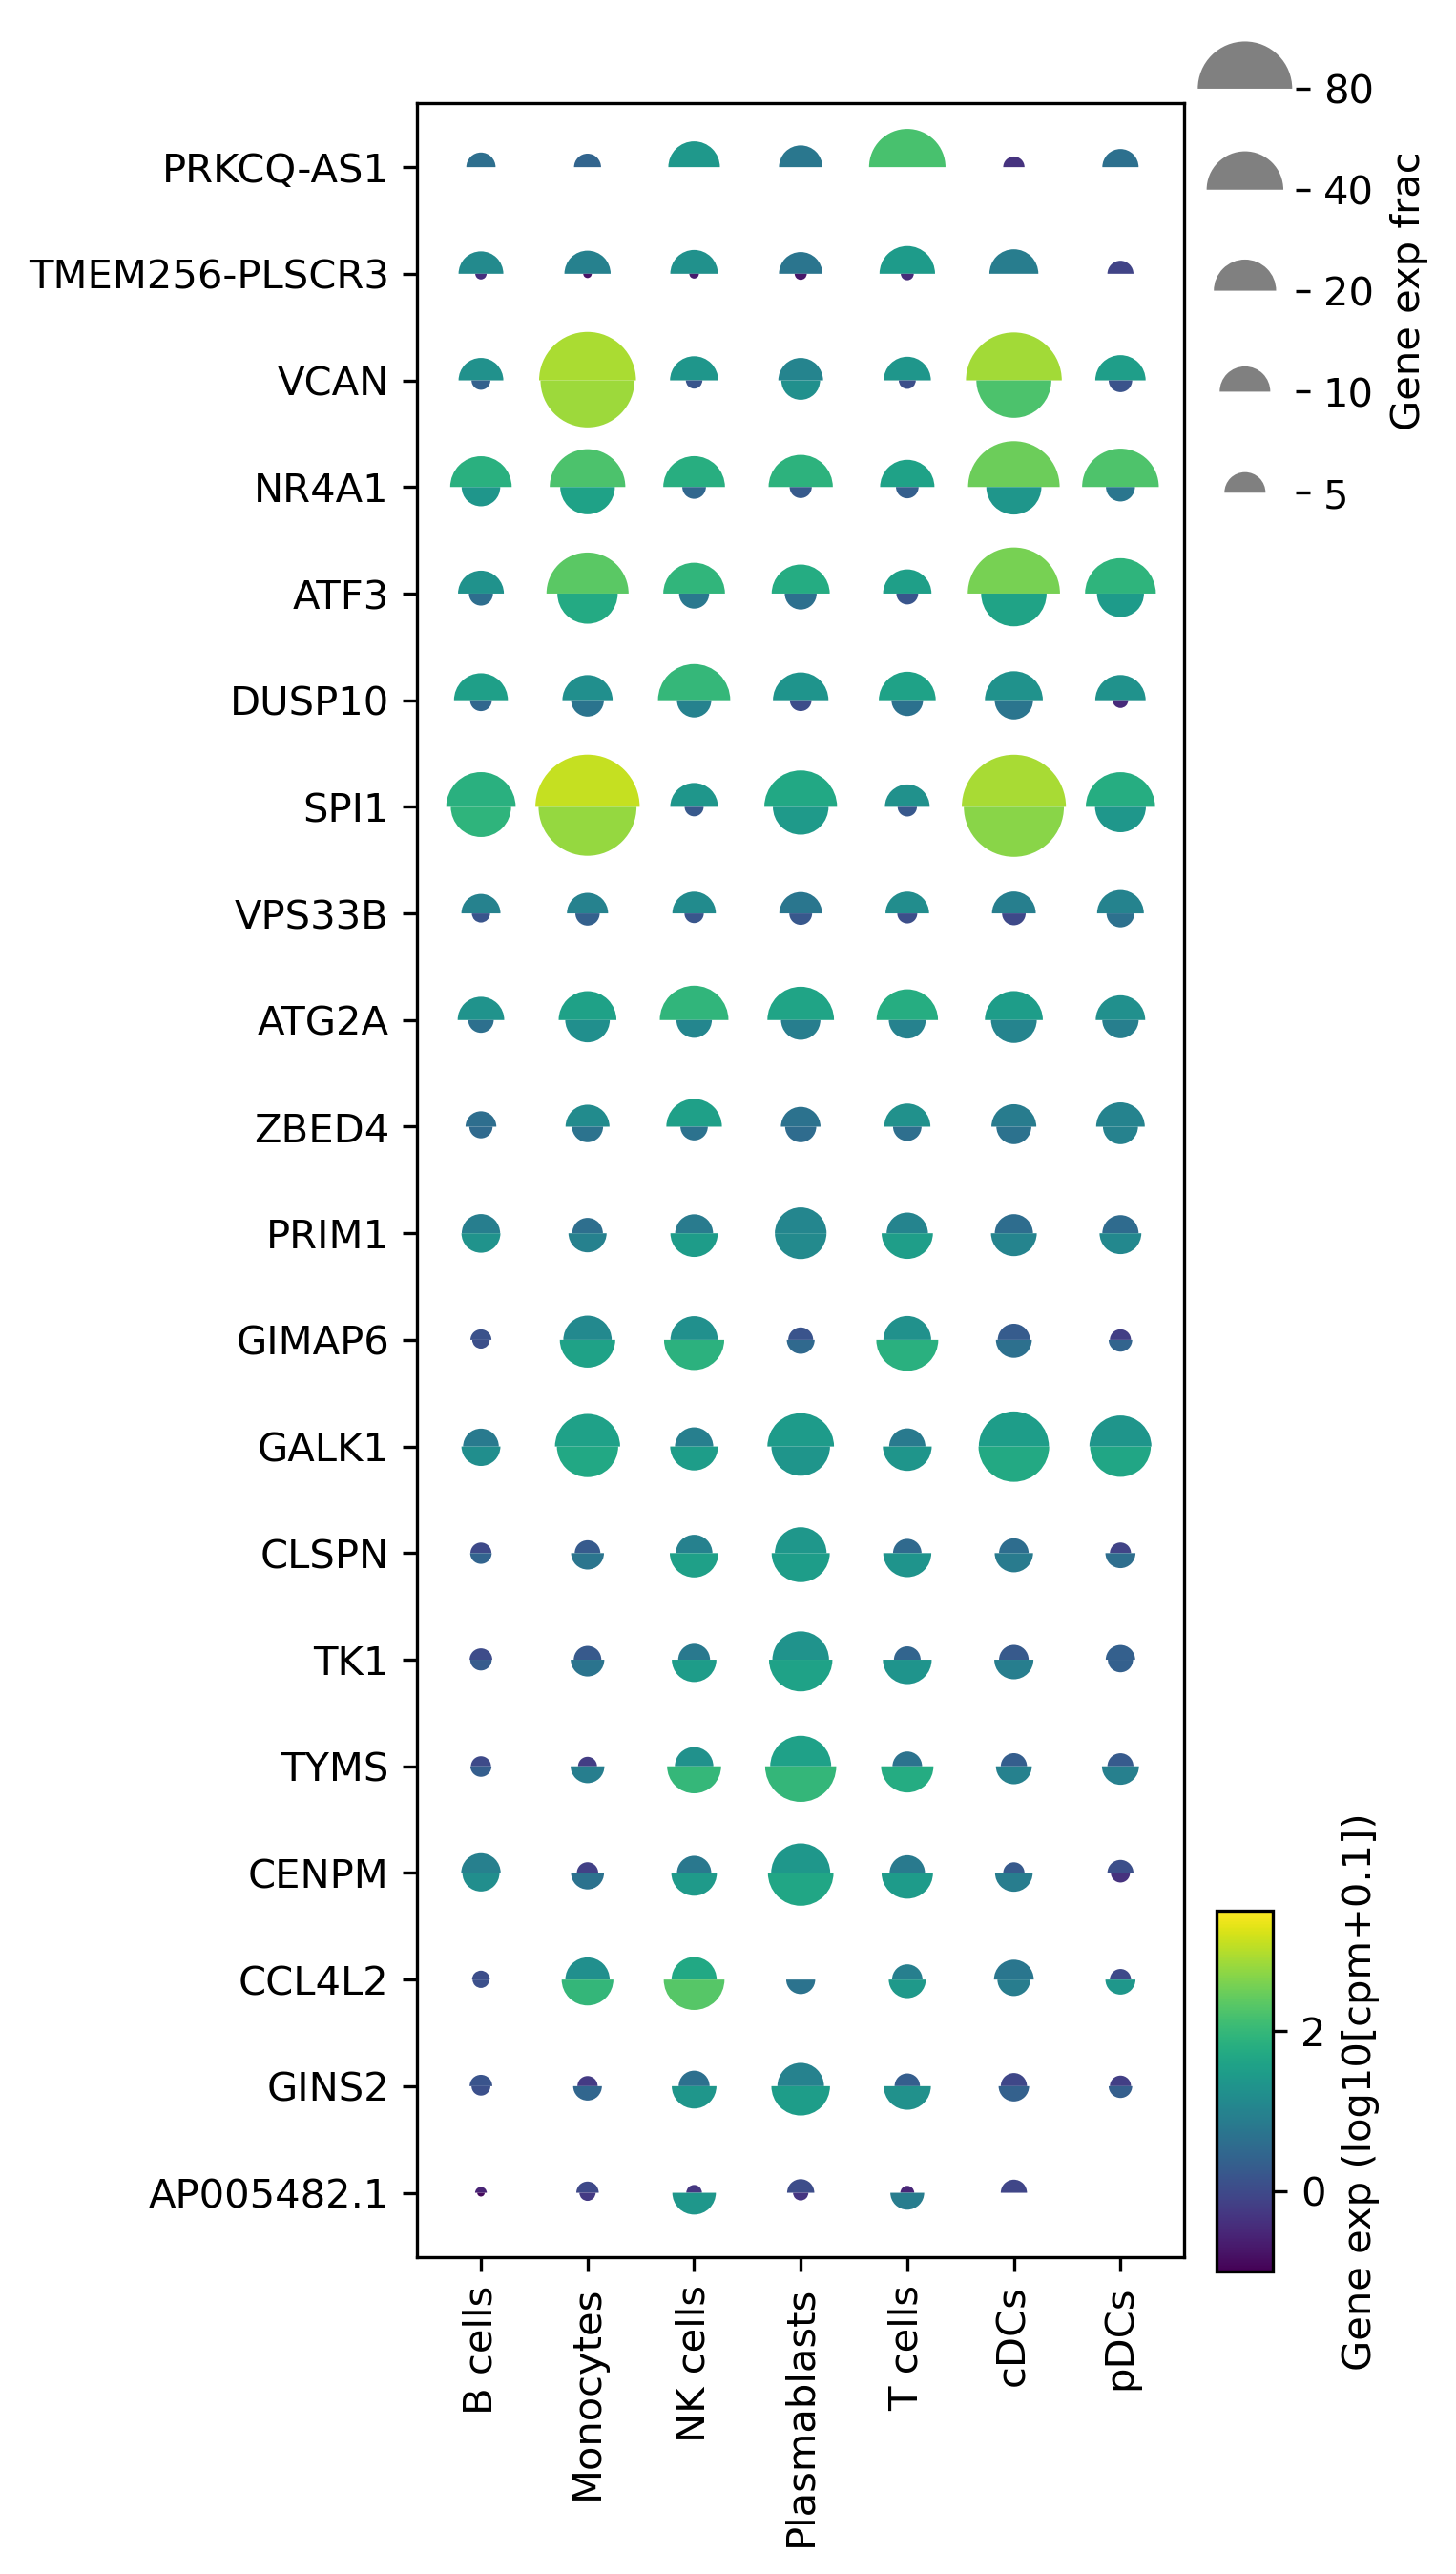

In [670]:
NK_genes = NK[:10].index.tolist() + NK[-10:].index.tolist()
mushrooms(NK_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

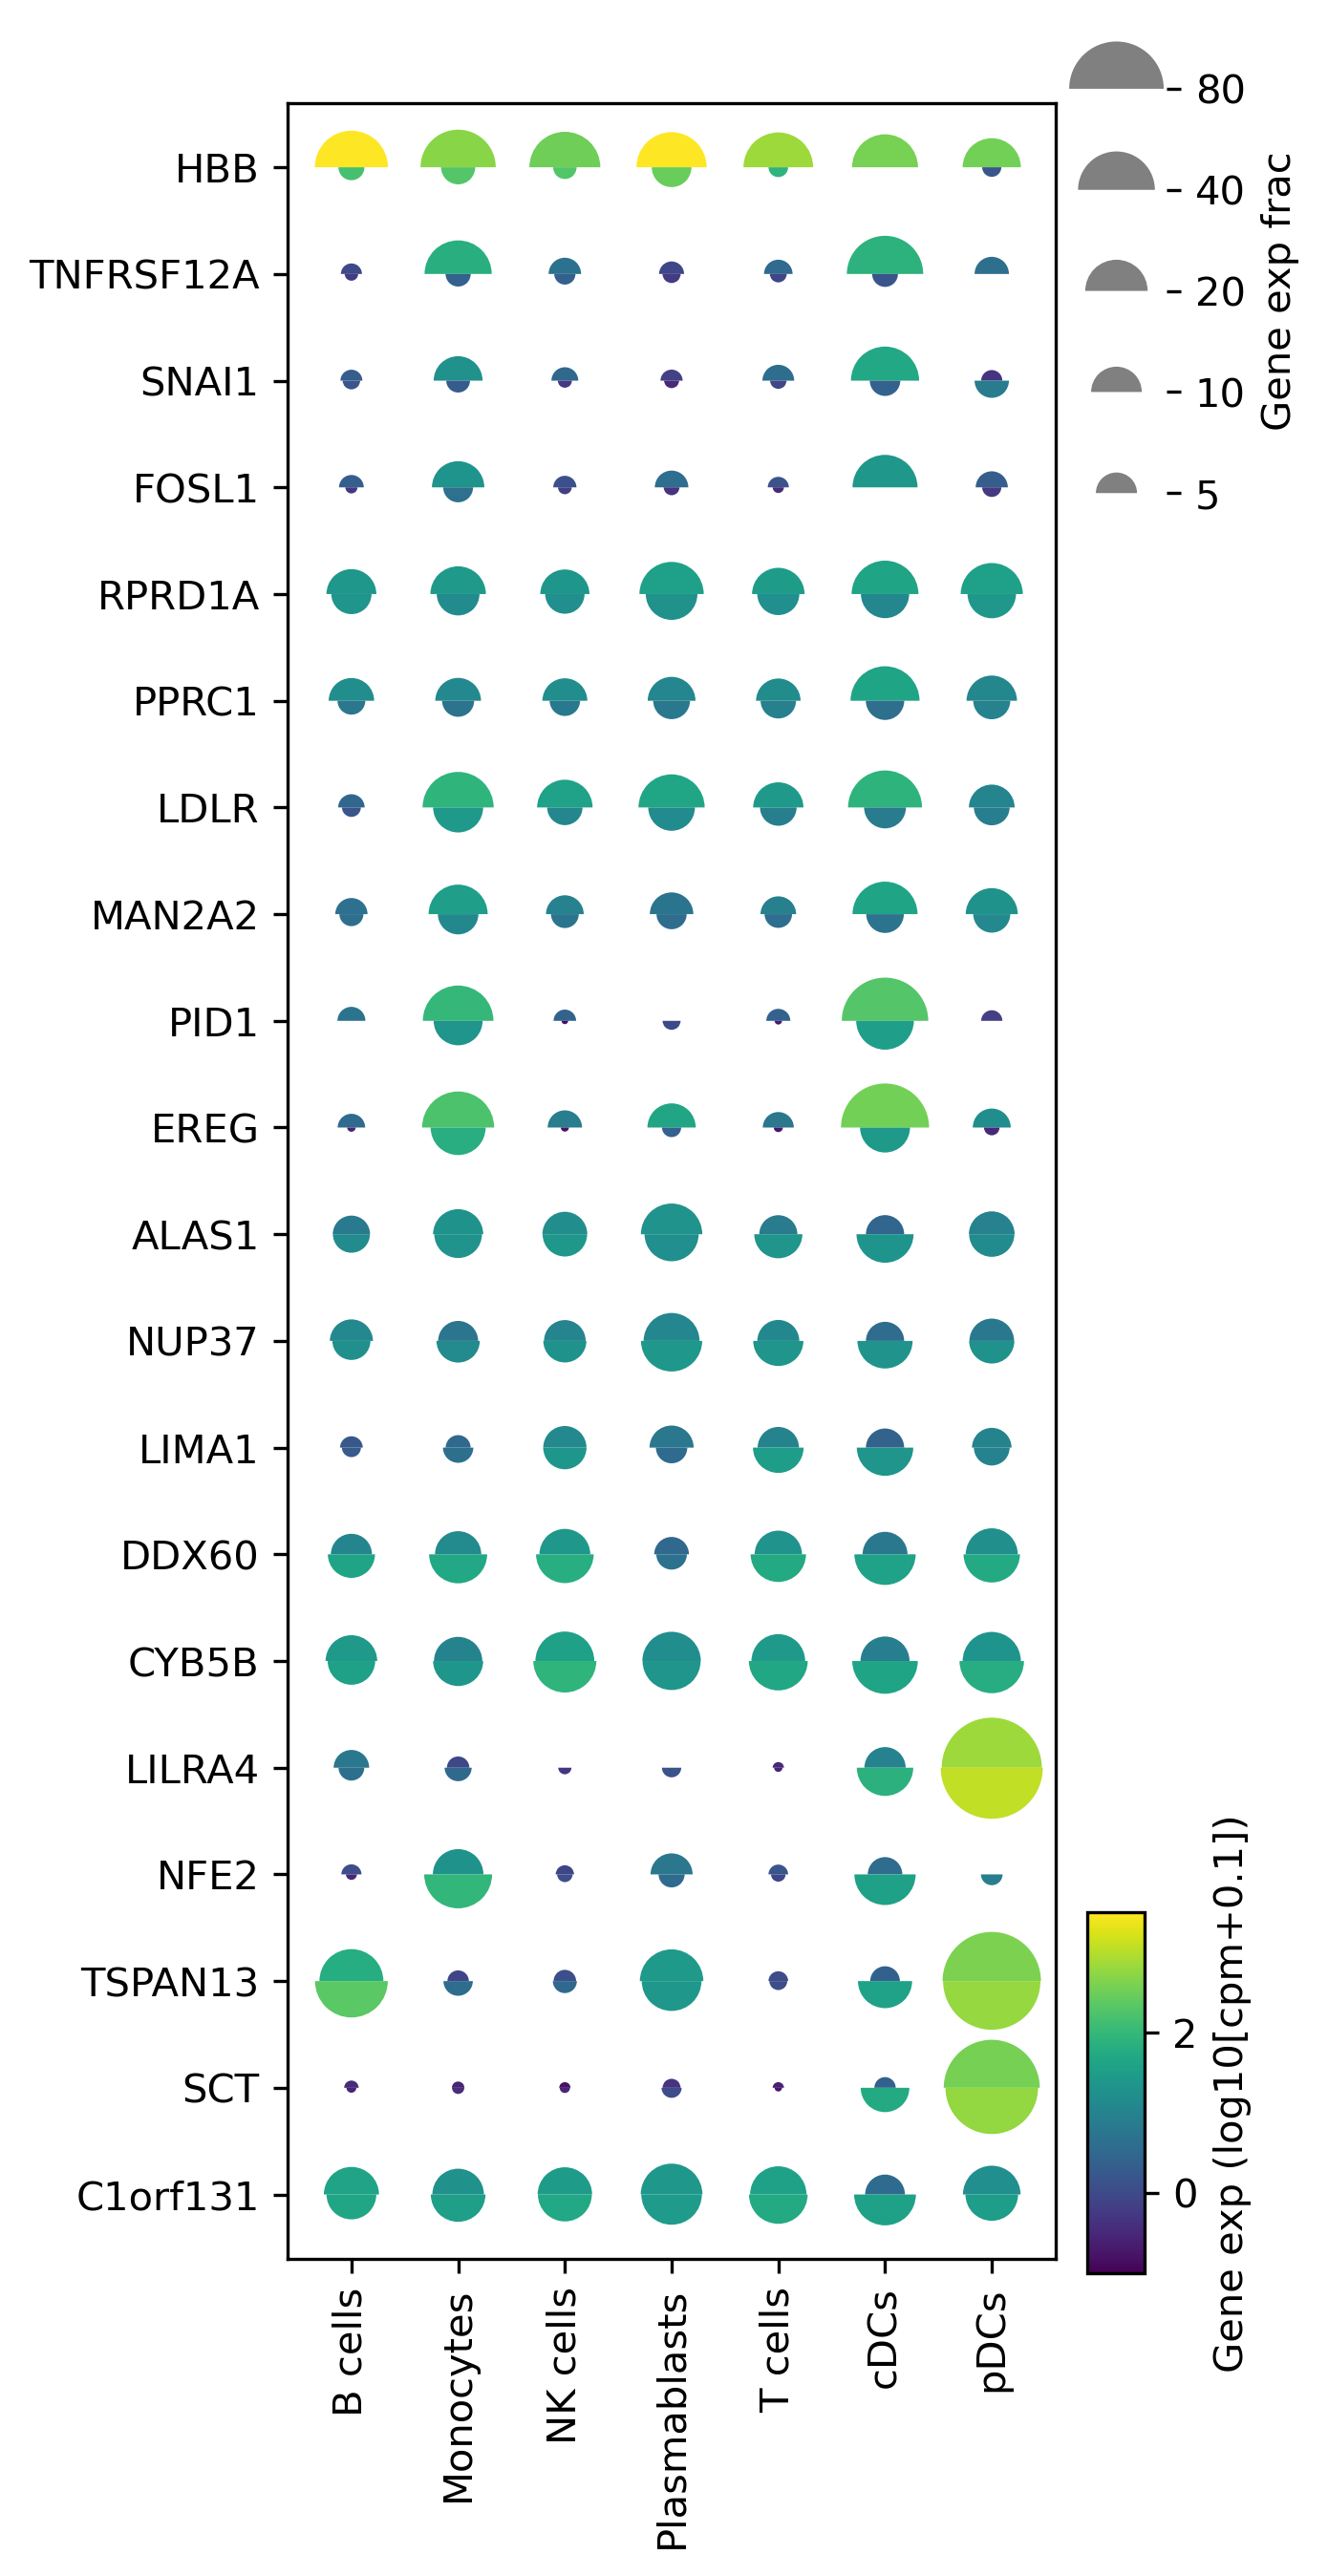

In [671]:
cDC_genes = cDC[:10].index.tolist() + cDC[-10:].index.tolist()
mushrooms(cDC_genes)

<ipython-input-661-ec37f2001780>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 1188x3780 with 3 Axes>, 'ax': <AxesSubplot:>}

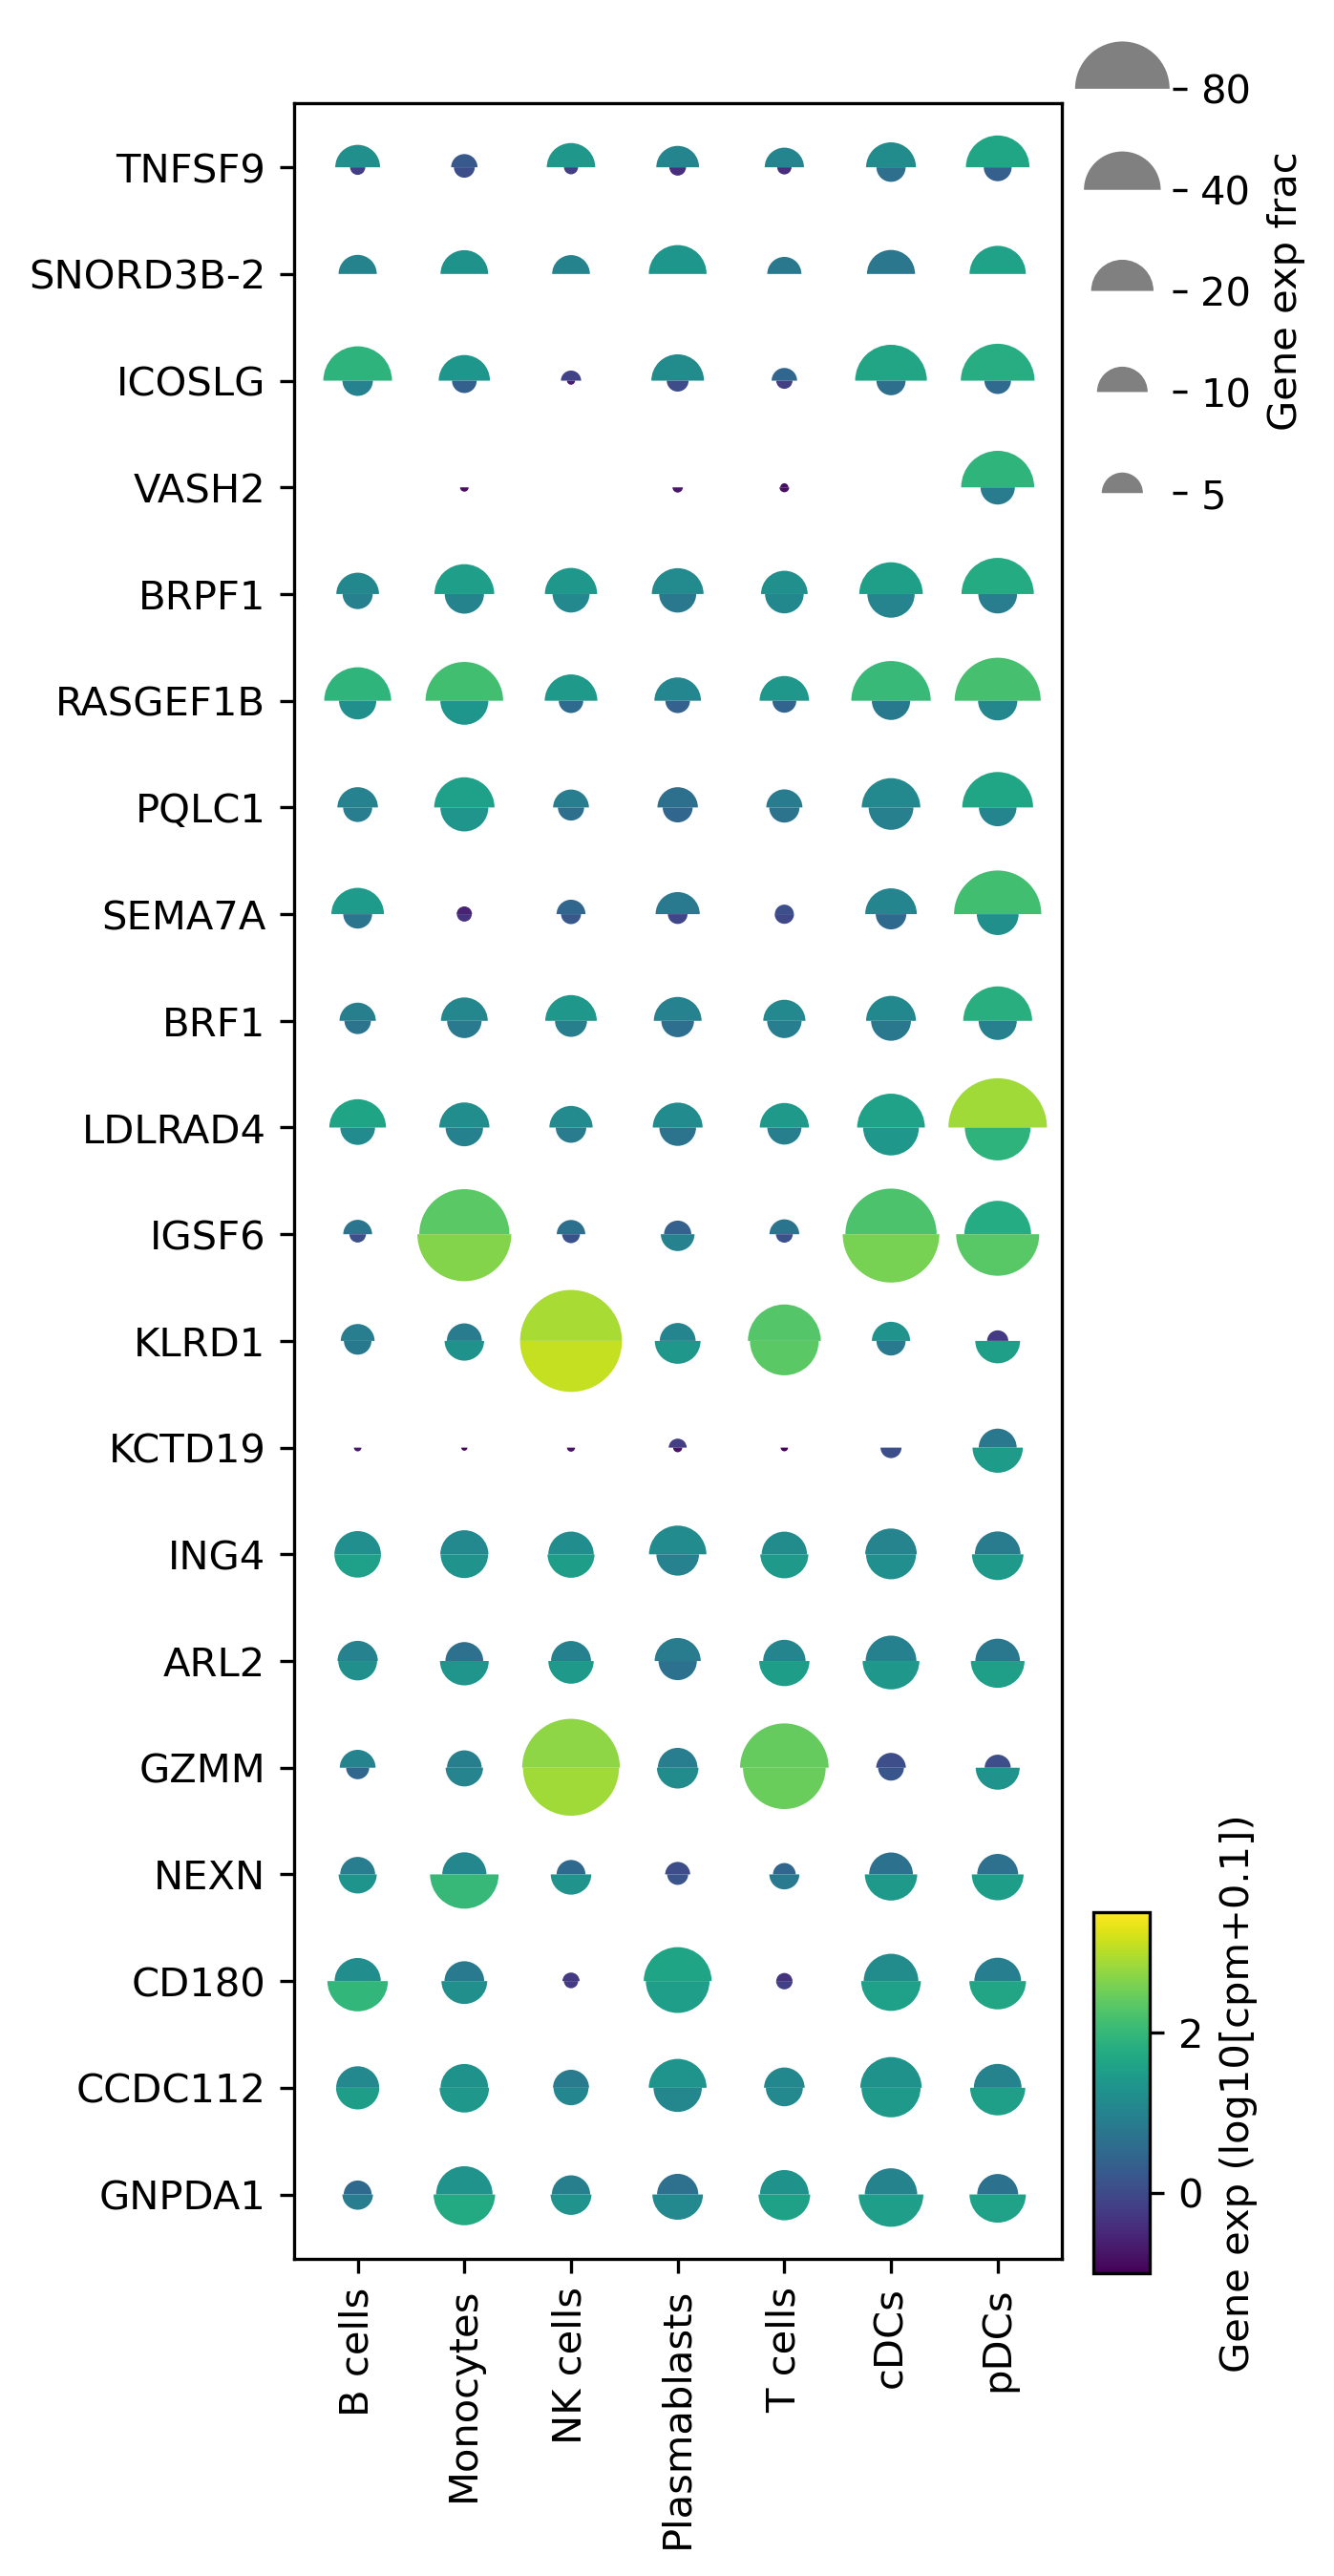

In [672]:
pDC_genes = pDC[:10].index.tolist() + pDC[-10:].index.tolist()
mushrooms(pDC_genes)